# TReconLM Custom Data Tutorial

This notebook demonstrates how to run TReconLM on your own data.

**Four options:**
1. **Quick test**: Use included example data (10 sequences)
2. **Microsoft DNA**: Use Microsoft dataset (requires running `../data/microsoft_data/microsoft_data.ipynb` first)
3. **Noisy DNA**: Use Noisy DNA dataset (requires running `../data/noisy_dna/noisyDNA_data.ipynb` first)
4. **Your own data**: Load your own `reads.txt` and `ground_truth.txt`

For synthetic datasets on HuggingFace, see: `quick_start.ipynb`

## 1. Setup

Import required libraries and helpers.

In [1]:
import os
import sys
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from IPython.display import display, Markdown

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import project modules
from src.gpt_pkg.model import GPT, GPTConfig
from src.eval_pkg.GPT_Inference import GPT_Inference
from src.utils.helper_functions import filter_string
from src.utils.hamming_distance import hamming_distance_postprocessed
from Levenshtein import distance as levenshtein_distance

# Import tutorial utilities
from utils import (
    get_model_info, 
    list_available_models, 
    load_vocabulary,
    validate_reads_file,
    validate_ground_truth_file,
    print_validation_results
)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Setup complete!
PyTorch version: 2.0.1+cu117
CUDA available: True
GPU: NVIDIA RTX A6000


## 2. Data Format Requirements

TReconLM expects two files:

`reads.txt`, Clustered noisy reads

Format: Each cluster separated by `===============================`

```
ACGTACGTACGT
ACGTACGTACGT
ACGTTACGTACGT
===============================
GGCCTTAACCGG
GGCCTTACCGG
===============================
```

**Requirements:**
- Only ACGT characters
- Each cluster must have 2-10 reads

`ground_truth.txt`, True sequences (one per cluster)

Format: One sequence per line (same order as clusters in `reads.txt`)

```
ACGTACGTACGT
GGCCTTAACCGG
```

**Requirements:**
- Only ACGT characters
- Number of lines must match number of clusters in `reads.txt`
- Sequence length should be 60, 110, or 180 (to match available model)

## 3. Choose Your Data Source

Select one of the following options:

In [2]:
# ========================================
# OPTION 1: Quick test with example data
# ========================================
# DATA_SOURCE = 'example'  # 10 synthetic sequences (110nt)

# ========================================
# OPTION 2: Microsoft DNA dataset
# ========================================
DATA_SOURCE = 'microsoft'
# First run ../data/microsoft_data/microsoft_data.ipynb
#            to generate the processed data files

# ========================================
# OPTION 3: Noisy DNA dataset
# ========================================
# DATA_SOURCE = 'noisy_dna'
# First run ../data/noisy_dna/noisyDNA_data.ipynb
#            to generate the processed data files

# ========================================
# OPTION 4: Your own data
# ========================================
# DATA_SOURCE = 'custom'
# READS_PATH = '/path/to/your/reads.txt'
# GT_PATH = '/path/to/your/ground_truth.txt'

print(f"Selected data source: {DATA_SOURCE}")

Selected data source: microsoft


## 4. Load and Validate Data

Load data based on your selection and validate the format.

In [3]:
# Set paths based on data source
if DATA_SOURCE == 'example':
    READS_PATH = 'example_data/reads.txt'
    GT_PATH = 'example_data/ground_truth.txt'
    SEQUENCE_LENGTH = 110
    MODEL_VARIANT = 'pretrained'
    
elif DATA_SOURCE == 'microsoft':
    # Microsoft DNA dataset (110nt sequences)
    READS_PATH = '../data/microsoft_data/data_microsoft/reads.txt'
    GT_PATH = '../data/microsoft_data/data_microsoft/ground_truth.txt'
    SEQUENCE_LENGTH = 110
    MODEL_VARIANT = 'microsoft'
    
    if not os.path.exists(READS_PATH):
        raise FileNotFoundError(
            "Microsoft data files not found.\n"
            "Please run: ../data/microsoft_data/microsoft_data.ipynb\n"
            "This will download and process the Microsoft DNA dataset."
        )
    
elif DATA_SOURCE == 'noisy_dna':
    # Noisy DNA dataset (60nt sequences)
    # Using non-cleaned version (fine-tuned model was trained with trailing C's)
    READS_PATH = '../data/noisy_dna/noisy_dna_data_storage/data/splits/reads.txt'
    GT_PATH = '../data/noisy_dna/noisy_dna_data_storage/data/splits/ground_truth.txt'
    SEQUENCE_LENGTH = 60
    MODEL_VARIANT = 'noisy_dna'
    
    if not os.path.exists(READS_PATH):
        raise FileNotFoundError(
            "Noisy DNA data files not found.\n"
            "Please run: ../data/noisy_dna/noisyDNA_data.ipynb\n"
            "This will download and process the Noisy DNA dataset."
        )
    
elif DATA_SOURCE == 'custom':
    # Your own data, set READS_PATH, GT_PATH, and SEQUENCE_LENGTH above
    if not 'READS_PATH' in locals():
        raise ValueError("Please set READS_PATH, GT_PATH, and SEQUENCE_LENGTH for custom data")
    
    MODEL_VARIANT = 'pretrained'
    
else:
    raise ValueError(f"Unknown DATA_SOURCE: {DATA_SOURCE}")

print(f"\nData paths:")
print(f"  Reads: {READS_PATH}")
print(f"  Ground truth: {GT_PATH}")
print(f"  Expected sequence length: {SEQUENCE_LENGTH}nt")
print(f"  Model variant: {MODEL_VARIANT}")


Data paths:
  Reads: ../data/microsoft_data/data_microsoft/reads.txt
  Ground truth: ../data/microsoft_data/data_microsoft/ground_truth.txt
  Expected sequence length: 110nt
  Model variant: microsoft


In [4]:
# Validate reads.txt format
reads_validation = validate_reads_file(READS_PATH)
print_validation_results(reads_validation, "reads")

if not reads_validation['valid']:
    raise ValueError("reads.txt validation failed! Please fix the errors above.")

[PASS] reads.txt validation passed
  Found 5109 clusters


In [5]:
# Validate ground_truth.txt format
gt_validation = validate_ground_truth_file(GT_PATH, expected_count=reads_validation['num_clusters'])
print_validation_results(gt_validation, "ground_truth")

if not gt_validation['valid']:
    raise ValueError("ground_truth.txt validation failed! Please fix the errors above.")

# Check sequence length compatibility
if gt_validation['sequence_lengths']:
    avg_length = np.mean(gt_validation['sequence_lengths'])
    if abs(avg_length - SEQUENCE_LENGTH) > 10:
        print(f"\nWARNING: Average sequence length ({avg_length:.0f}nt) differs from selected model ({SEQUENCE_LENGTH}nt)")
        print("Consider using a model with matching sequence length for best results.")

[PASS] ground_truth.txt validation passed
  Found 5109 sequences


## 5. Load Data into Memory

Parse the text files and prepare for inference.

In [6]:
# Load reads.txt
with open(READS_PATH, 'r') as f:
    content = f.read()

separator = "==============================="
clusters = content.split(separator)
clusters = [c.strip().split('\n') for c in clusters if c.strip()]

# Filter clusters with invalid size (< 2 or > 10)
valid_clusters = [c for c in clusters if 2 <= len(c) <= 10]

print(f"Loaded {len(clusters)} clusters from reads.txt")
if len(valid_clusters) < len(clusters):
    print(f"  Filtered to {len(valid_clusters)} valid clusters (size 2-10)")
    
# Load ground_truth.txt
with open(GT_PATH, 'r') as f:
    all_ground_truths = [line.strip() for line in f if line.strip()]

# Match ground truths to valid clusters
valid_indices = [i for i, c in enumerate(clusters) if 2 <= len(c) <= 10]
ground_truths = [all_ground_truths[i] for i in valid_indices]

print(f"Loaded {len(ground_truths)} ground truth sequences")

# Analyze cluster size distribution
cluster_sizes = [len(c) for c in valid_clusters]
from collections import Counter
size_counts = Counter(cluster_sizes)

print(f"\nCluster size distribution:")
for size in sorted(size_counts.keys()):
    print(f"  Size {size}: {size_counts[size]} clusters")

# Create input format for inference (pipe-separated reads + colon + ground truth length)
inputs = []
for cluster, gt in zip(valid_clusters, ground_truths):
    reads_str = '|'.join(cluster)
    input_str = f"{reads_str}:{gt}"  # Model uses GT for length reference during inference
    inputs.append(input_str)

print(f"\nPrepared {len(inputs)} examples for inference")

Loaded 5109 clusters from reads.txt
Loaded 5109 ground truth sequences

Cluster size distribution:
  Size 2: 964 clusters
  Size 3: 668 clusters
  Size 4: 583 clusters
  Size 5: 556 clusters
  Size 6: 511 clusters
  Size 7: 491 clusters
  Size 8: 455 clusters
  Size 9: 443 clusters
  Size 10: 438 clusters

Prepared 5109 examples for inference


## 6. Download and Load Model

In [7]:
# Display available models
display(Markdown(list_available_models()))


### Available Models

| Length | Variant | Model Name | Description |
|--------|---------|------------|-------------|
| 60nt | pretrained | model_seq_len_60.pt | Pretrained on synthetic IDS data |
| 60nt | noisy_dna | finetuned_noisy_dna_len60.pt | Fine-tuned on Noisy DNA dataset |
| 110nt | pretrained | model_seq_len_110.pt | Pretrained on synthetic IDS data |
| 110nt | microsoft | finetuned_microsoft_dna_len110.pt | Fine-tuned on Microsoft DNA dataset |
| 180nt | pretrained | model_seq_len_180.pt | Pretrained on synthetic IDS data |

**Block sizes:** 60nt=800, 110nt=1500, 180nt=2400


In [8]:
# Get model info
model_info = get_model_info(SEQUENCE_LENGTH, MODEL_VARIANT)
print(f"Selected model: {model_info['model_name']}")
print(f"Description: {model_info['description']}")
print(f"Block size: {model_info['block_size']}")

# Download model from HuggingFace
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id=model_info['repo_id'],
    filename=model_info['model_name'],
    cache_dir='./models'
)

print(f"\nModel downloaded to: {model_path}")

Selected model: finetuned_microsoft_dna_len110.pt
Description: Fine-tuned on Microsoft DNA dataset (110nt)
Block size: 1500

Model downloaded to: ./models/models--mli-lab--TReconLM/snapshots/950d152df4daab579e7ef6e65cfb6566b9c392a9/finetuned_microsoft_dna_len110.pt


In [14]:
# Load checkpoint and build model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(model_path, map_location='cpu')

model_args = ckpt['model_args']
# Remove 'model_type' if present, as GPTConfig doesn't accept it
config_args = {k: v for k, v in model_args.items() if k != 'model_type'}

# Fix checkpoint keys (remove '_orig_mod.' prefix from torch.compile)
state_dict = ckpt['model']
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('_orig_mod.'):
        new_key = key.replace('_orig_mod.', '')
        new_state_dict[new_key] = value
    else:
        new_state_dict[key] = value

model = GPT(GPTConfig(**config_args))
model.load_state_dict(new_state_dict, strict=True)
model = model.half().to(device).eval()

print(f"Model loaded on {device}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

Model loaded on cuda
  Parameters: 38.5M


## 8. Run Inference

In [10]:
# Load vocabulary
stoi, itos = load_vocabulary()
decode = lambda t: ''.join(itos[i] for i in t)
encode_str = lambda s: [stoi.get(ch, stoi.get('<unk>', 0)) for ch in s]

# Inference parameters
batch_size = 200  # Adjust based on GPU memory
temperature = 1.0
greedy = True  # Set False for beam search

# Setup autocast for mixed precision
ctx = torch.amp.autocast('cuda', dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16)

# Inference parameters for GPT_Inference
inf_params = {
    'model': model,
    'ctx': ctx,
    'device': device,
    'stoi': stoi,
    'itos': itos,
    'encode': encode_str,
    'decode': decode,
    'temperature': temperature,
    'greedy': greedy,
    'ground_truth_length': SEQUENCE_LENGTH,
    'block_size': model_info['block_size'],
    'target_type': 'CPRED',
    'constrained_generation': True
}

print(f"Running inference on {len(inputs)} examples...")
print(f"  Batch size: {batch_size}")
print(f"  Strategy: {'Greedy' if greedy else 'Beam search'}")
print(f"  Device: {device}")

Running inference on 5109 examples...
  Batch size: 200
  Strategy: Greedy
  Device: cuda


In [11]:
# Run inference in batches with length-based sorting for efficiency
# Sort by length to minimize padding and keep Flash Attention enabled
all_results = []

# Calculate lengths and create index mapping
examples_with_len = []
for idx, (inp, gt) in enumerate(zip(inputs, ground_truths)):
    prefix_len = len(inp.split(':')[0])
    examples_with_len.append((idx, inp, gt, prefix_len))

# Sort by length (ascending) - similar lengths will be batched together
examples_with_len.sort(key=lambda x: x[3])

# Run inference on sorted batches
sorted_results = []
with torch.inference_mode(), ctx:
    for start_idx in tqdm(range(0, len(examples_with_len), batch_size), desc="Inference"):
        batch_examples = examples_with_len[start_idx:start_idx + batch_size]
        
        batch_indices = [ex[0] for ex in batch_examples]
        batch_inputs = [ex[1] for ex in batch_examples]
        batch_gts = [ex[2] for ex in batch_examples]
        
        # Get cluster sizes
        alignment_sizes = [len(inp.split(':')[0].split('|')) for inp in batch_inputs]
        
        # Run inference
        out = GPT_Inference(inf_params).inference(batch_inputs, alignment_size=alignment_sizes)
        predictions = out['candidate_sequences']
        
        # Store results with original indices
        for orig_idx, inp, gt, pred, cluster_size in zip(batch_indices, batch_inputs, batch_gts, predictions, alignment_sizes):
            pred_filtered = filter_string(pred)[:len(gt)]
            
            ham_dist = hamming_distance_postprocessed(gt, pred_filtered)
            lev_dist = levenshtein_distance(gt, pred_filtered) / len(gt)
            
            sorted_results.append({
                'original_index': orig_idx,
                'input': inp,
                'cluster_size': cluster_size,
                'ground_truth': gt,
                'prediction': pred_filtered,
                'hamming': ham_dist,
                'levenshtein': lev_dist
            })

# Restore original order
sorted_results.sort(key=lambda x: x['original_index'])
all_results = [{k: v for k, v in r.items() if k != 'original_index'} for r in sorted_results]

print(f"\nInference complete! Processed {len(all_results)} examples")

Inference: 100%|██████████| 26/26 [03:14<00:00,  7.48s/it]


Inference complete! Processed 5109 examples


In [12]:
# Offload model from GPU to free memory
import gc

del model
gc.collect()
torch.cuda.empty_cache()

print("GPU memory freed")

GPU memory freed


## 9. Evaluate Results

In [15]:
# Overall metrics
all_hamming = [r['hamming'] for r in all_results]
all_levenshtein = [r['levenshtein'] for r in all_results]

print("="*60)
print("OVERALL RESULTS")
print("="*60)
print(f"Total examples: {len(all_results)}")
print(f"Mean Hamming distance: {np.mean(all_hamming):.4f} ± {np.std(all_hamming):.4f}")
print(f"Mean Levenshtein distance: {np.mean(all_levenshtein):.4f} ± {np.std(all_levenshtein):.4f}")
print(f"Perfect reconstructions: {sum(h == 0 for h in all_hamming)} ({100*sum(h == 0 for h in all_hamming)/len(all_hamming):.2f}%)")
print("="*60)

OVERALL RESULTS
Total examples: 5109
Mean Hamming distance: 0.0966 ± 0.1994
Mean Levenshtein distance: 0.0108 ± 0.0215
Perfect reconstructions: 3607 (70.60%)


In [16]:
# Performance by cluster size
by_cluster = defaultdict(list)
for r in all_results:
    by_cluster[r['cluster_size']].append(r)

print("\nRESULTS BY CLUSTER SIZE")
print("="*80)
print(f"{'Size':<6} {'Count':<8} {'Mean Ham':<12} {'Mean Lev':<12} {'Perfect %':<10}")
print("-"*80)

for size in sorted(by_cluster.keys()):
    results = by_cluster[size]
    hamming_vals = [r['hamming'] for r in results]
    lev_vals = [r['levenshtein'] for r in results]
    perfect_pct = 100 * sum(h == 0 for h in hamming_vals) / len(hamming_vals)
    
    print(f"{size:<6} {len(results):<8} {np.mean(hamming_vals):<12.4f} {np.mean(lev_vals):<12.4f} {perfect_pct:<10.2f}%")

print("="*80)


RESULTS BY CLUSTER SIZE
Size   Count    Mean Ham     Mean Lev     Perfect % 
--------------------------------------------------------------------------------
2      964      0.3163       0.0422       11.00     %
3      668      0.1351       0.0128       51.05     %
4      583      0.0622       0.0046       77.02     %
5      556      0.0368       0.0025       86.87     %
6      511      0.0280       0.0014       91.00     %
7      491      0.0197       0.0009       94.91     %
8      455      0.0166       0.0007       96.26     %
9      443      0.0152       0.0006       96.39     %
10     438      0.0074       0.0003       98.63     %


## 10. Visualize Results

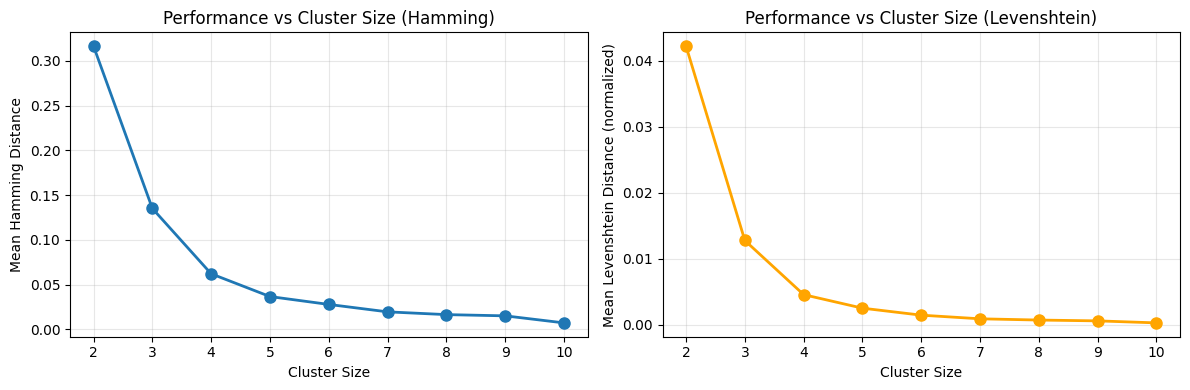

In [17]:
import matplotlib.pyplot as plt

# Only plot if we have multiple cluster sizes
if len(by_cluster) > 1:
    # Plot performance vs cluster size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    cluster_sizes_sorted = sorted(by_cluster.keys())
    mean_hamming_by_size = [np.mean([r['hamming'] for r in by_cluster[size]]) for size in cluster_sizes_sorted]
    mean_lev_by_size = [np.mean([r['levenshtein'] for r in by_cluster[size]]) for size in cluster_sizes_sorted]

    # Hamming distance
    ax1.plot(cluster_sizes_sorted, mean_hamming_by_size, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Mean Hamming Distance')
    ax1.set_title('Performance vs Cluster Size (Hamming)')
    ax1.grid(True, alpha=0.3)

    # Levenshtein distance
    ax2.plot(cluster_sizes_sorted, mean_lev_by_size, 'o-', linewidth=2, markersize=8, color='orange')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Mean Levenshtein Distance (normalized)')
    ax2.set_title('Performance vs Cluster Size (Levenshtein)')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot, only one cluster size in dataset")

## 11. Example Predictions

In [18]:
# Show 5 random examples
import random

sample_results = random.sample(all_results, min(5, len(all_results)))

print("\nEXAMPLE PREDICTIONS")
print("="*80)

for i, r in enumerate(sample_results, 1):
    print(f"\nExample {i} (Cluster size: {r['cluster_size']})")
    print(f"  Hamming: {r['hamming']}, Levenshtein: {r['levenshtein']:.4f}")
    print(f"  Ground Truth: {r['ground_truth']}")
    print(f"  Prediction:   {r['prediction']}")
    
    # Show differences
    if r['hamming'] > 0:
        diff_positions = [i for i, (a, b) in enumerate(zip(r['ground_truth'], r['prediction'])) if a != b]
        print(f"  Differences at positions: {diff_positions[:10]}{'...' if len(diff_positions) > 10 else ''}")


EXAMPLE PREDICTIONS

Example 1 (Cluster size: 8)
  Hamming: 0.0, Levenshtein: 0.0000
  Ground Truth: TGGCATGTCGTTACAGGACACAAGGCCGTCAGAAGTCCCTTACTTGGTGTAGATTACCGCATTAACTGTATGGATTTCTGACGTTCGTTTCTCCATATCGACGCGGCTCA
  Prediction:   TGGCATGTCGTTACAGGACACAAGGCCGTCAGAAGTCCCTTACTTGGTGTAGATTACCGCATTAACTGTATGGATTTCTGACGTTCGTTTCTCCATATCGACGCGGCTCA

Example 2 (Cluster size: 8)
  Hamming: 0.0, Levenshtein: 0.0000
  Ground Truth: ATCGTGGCATCCCAAAATTATCTAAGTGGCTACTAGCTTTTGGGCGCGCAGGACTCTCCGGCATGTAGTTAAGGTGTCGAGCACTACAGGGTGGCACAGGCGTGCGGCTC
  Prediction:   ATCGTGGCATCCCAAAATTATCTAAGTGGCTACTAGCTTTTGGGCGCGCAGGACTCTCCGGCATGTAGTTAAGGTGTCGAGCACTACAGGGTGGCACAGGCGTGCGGCTC

Example 3 (Cluster size: 4)
  Hamming: 0.0, Levenshtein: 0.0000
  Ground Truth: TAACCCTAGGCGCCCACGGTTAATTAGCGTCATAAGTATGCGGCCCGGCCTGAAGGCCTAGACTCAGGCAGCATTCGAATTTACCGCCTCTCGGGTCACGGAGCGTATTA
  Prediction:   TAACCCTAGGCGCCCACGGTTAATTAGCGTCATAAGTATGCGGCCCGGCCTGAAGGCCTAGACTCAGGCAGCATTCGAATTTACCGCCTCTCGGGTCACGGAGCGTATTA

Example 4 (Cluster si

## 12. Export Results

In [ ]:
# Export predictions to file
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# Save predictions
predictions_file = output_dir / f'{DATA_SOURCE}_predictions.txt'
with open(predictions_file, 'w') as f:
    for r in all_results:
        f.write(f"{r['prediction']}\n")

print(f"Predictions saved to: {predictions_file}")

# Save detailed results as CSV
import pandas as pd

results_df = pd.DataFrame([
    {
        'cluster_size': r['cluster_size'],
        'ground_truth': r['ground_truth'],
        'prediction': r['prediction'],
        'hamming_distance': r['hamming'],
        'levenshtein_distance': r['levenshtein']
    }
    for r in all_results
])

results_csv = output_dir / f'{DATA_SOURCE}_results.csv'
results_df.to_csv(results_csv, index=False)

print(f"Detailed results saved to: {results_csv}")
print(f"\nResults exported to {output_dir}/")

Predictions saved to: results/example_predictions.txt
Detailed results saved to: results/example_results.csv

Results exported to results/
